Collecting the data for the quantum vertex amplitude for the 1-periodic case. In this case, the initial and final spin are equal, while on the 3-frusta spins k, no condition is imposed. This leaves us with a pair of spins (j,k), for which we need to compute the quantum amplitudes. 

From the intertwiner data, I infer that Int1j and Int5j are the 3-cubes while the other intertwiners correspond to the 3-frusta. Apparently, for the 3-frusta intertwiners, the first two spins are the ones of the initial and final spin, while the third spin is the one of the sides, k.

In [1]:
using JLD, LinearAlgebra, Cuba, SparseArrays, CSV, DataFrames, TensorOperations, BenchmarkTools, Plots, LaTeXStrings

In [2]:
# Codes for the semi-classical amplitudes
include("/ssd/ri47hud/codes/Spectral Dimension/basic_frusta.jl")
include("/ssd/ri47hud/codes/Spectral Dimension/laplacians_v3.jl")
include("/ssd/ri47hud/codes/Spectral Dimension/vertex_ampl.jl")
include("/ssd/ri47hud/codes/Spectral Dimension/return_prob_v2.jl")

# Codes for the intertwiners and quantum amplitudes
include("/ssd/ri47hud/codes/Frusta quantum amplitude/quantum_amplitude.jl")

QExpval_P1 (generic function with 1 method)

The code below visualizes the exclusion of spins due to the Riemannian EPRL-condition.

In [ ]:
gammas = [i for i in 0.001:0.001:0.999]
config_ratio = [length(filter(x -> EPRL_cond(x, gamma) == 1, [0.5*(i-1)+1 for i in 1:19999]))/length([0.5*(i-1)+1 for i in 1:19999]) for gamma in gammas]
fig = scatter(gammas, config_ratio, legend=false, fmt=:png, xlabel="\\gamma", ylabel="N/N_spins")
savefig(fig, "EPRL_condition.png")

A value for gamma of 0.5 exlcudes the smallest amount of spins, which are then evenly spaced even integers, as shown below.

In [21]:
N = 16
println("SU2-spins allowed by the EPRL-condition = ", filter(x -> EPRL_cond(x, 0.5) == 1, [0.5*(i - 1) + 0.5 for i in 1:N]))

SU2-spins allowed by the EPRL-condition = [2.0, 4.0, 6.0, 8.0]


These are the SU2-spins that are allowed by the EPRL-condition. The Spin4-spins j+ and j- are then determined by the j. For gamma = 0.5, these are given by

In [12]:
jmin = 0.5function Expval_P1_alt(alpha::Float64, G::Float64, γ::Float64, Lambda::Float64, return_prob1, j_min::Float64, j_max::Float64)

len_tau_range = length(return_prob1[1,:])
rp1 = Array(return_prob1)

res = zeros(Float64, len_tau_range)
mul!(res, transpose(rp1), Ampl_vector(alpha, G, γ, Lambda, j_min, j_max)) 

res *= 1/(Z1(alpha, G, γ, Lambda, j_min, j_max))

return res
grows
end
spins = [0.5*(i-1) + jmin for i in 1:N]
println("j+ in ", [3/4*i for i in spins if EPRL_cond(i, 0.5) == 1], ". ", "j- in ", [1/4*i for i in spins if EPRL_cond(i, 0.5) == 1], ".")

j+ in [1.5, 3.0, 4.5, 6.0]. j- in [0.5, 1.0, 1.5, 2.0].


Going up to SU2-spin j = 8, all of the required intertwiners for the Amplitude A- are there. For the amplitude A+, there are interwiners missing, namely all those for spin 4.5 or higher. These we need to generate after the Cluster is back to life. Until then, I want to write an algorithm that can take vertex data and return the quantum vertex amplitude as a vector, ready for being contracted with the return probability.

In [ ]:
N = 8
SU2_spins = [0.5*(i - 1) + 0.5 for i in 1:N]
SU2_Vamp = zeros(ComplexF64, N, N)
for j in 1:3
    for k in 1:8
        SU2_Vamp[j,k] = load("Cluster Files/QVertex_amp/A$j$j$k.jld", "A$j$j$k")
    end
end
save("Cluster Files/QVertex_amp/SU2_Vamp.jld", "SU2_Vamp", SU2_Vamp)

Read the CSV dataframe, turn it into array and insert the new components

In [ ]:
CSV.read("Cluster Files/Q_amps/SU2_Vamp_full.csv", DataFrame, header=false)
#Vamp = CSV.File("Cluster Files/Q_amps/SU2_Vamp_full.csv", header=false) |> Tables.matrix
Vamp[5,1:7] = [real.(load("Cluster Files/Q_amps/A55$i.jld", "A55$i")) for i in 1:7]

In [58]:
CSV.write("Cluster Files/Q_amps/SU2_Vamp_full.csv", DataFrame((Vamp), :auto), header = false)

"Cluster Files/Q_amps/SU2_Vamp_full.csv"

In [54]:
SU2_Eamp = zeros(Float64, N, N, 8) # The first two indices label the spin of the intertwiners and the third index indicates the intertwiner
for j in 1:3real.(SU2_Vamp[1,:])
        end
    end
end
SU2_Eamp
save("Cluster Files/Q_amps/SU2_Eamp.jld", "SU2_Eamp", SU2_Eamp)

In [ ]:
SU2_Vamp = load("Cluster Files/Q_amps/SU2_Vamp.jld", "SU2_Vamp")

In [12]:
CSV.write("Cluster Files/Q_amps/SU2_Vamp.csv", DataFrame(real.(SU2_Vamp), :auto), header = false)

"Cluster Files/Q_amps/SU2_Vamp.csv"

I need to generate the correct semi-classical vertex amplitude in order to make a comparison to the full one.

In [17]:
SU2_Vamp_semi = [real(VAmpSU2(0.5*j, 0.5*j, 0.5*k)) for j in  1:8, k in 1:8]
CSV.write("Cluster Files/Q_amps/SU2_Eamp_semi1.csv", DataFrame(SU2_Eamp_semi, :auto), header = false)
SU2_Vamp_semi_large = [real(VAmpSU2(0.5*j, 0.5*j, 0.5*k)) for j in 1:10000, k in 1:10000]
CSV.write("Cluster Files/Q_amps/SU2_Vamp_semi_large.csv", DataFrame(SU2_Vamp_semi_large, :auto), header = false)

"Cluster Files/Q_amps/SU2_Vamp_semi_large.csv"

Let's insert the remaining elements of the quantum vertex amplitude

In [10]:
SU2_Vamp = CSV.File("Cluster Files/Q_amps/SU2_Vamp_full.csv", header=false) |> Tables.matrix
SU2_Vamp[6,1:7] = [Float64.(real.(load("Cluster Files/Q_amps/A66$i.jld", "A66$i"))) for i in 1:7]
SU2_Vamp[7,1:6] = [Float64.(real.(load("Cluster Files/Q_amps/A77$i.jld", "A77$i"))) for i in 1:6]
CSV.write("Cluster Files/Q_amps/SU2_Vamp_full.csv", DataFrame(SU2_Vamp, :auto), header = false)

"Cluster Files/Q_amps/SU2_Vamp_full.csv"

Import the extrapolated quantum amplitude

In [ ]:
SU2_Vamp_extra = CSV.File("Cluster Files/Q_amps/SU2_Vamp_extra.csv", header=false) |> Tables.matrix

In [ ]:
using Plots
SU2_semi = [real(VAmpSU2(0.5*j, 0.5*j, 4.0*j)) for j in 1:1000]
SU2_Vamp_diag = [SU2_Vamp_extra[j,8j] for j in 1:1000]
rel_err = [(SU2_semi[i] - SU2_Vamp_diag[i])/SU2_Vamp_diag[i] for i in 1:1000]

In [38]:
fig = plot(rel_err, label="rel. error", xlabel="j", ylabel="\\epsilon", fmt=:png)
savefig(fig, "relerr_semi_vs_extra")

"/home/ri47hud/codes/Frusta quantum amplitude/relerr_semi_vs_extra.png"

Let's now come to the edge amplitude. First, we generate a matrix of semi-classical edge amplitudes.

In [5]:
CSV.write("Cluster Files/Q_amps/SU2_Eamp_semi.csv", DataFrame([EAmpSU2(0.5*j, 0.5*j, 0.5*k) for j in 1:10000, k in 1:10000], :auto), header = false)

"Cluster Files/Q_amps/SU2_Eamp_semi.csv"

In [5]:
SU2_Eamp_frustum = zeros(8,8)
for j in 1:8
    for k in 1:8
        name = "Cluster Files/Intertwiners/Int2j" * string("[",j,", ",j,", ",k,"]") * ".txt"
        int2 = ContractionMod.fromTxt2(name,[j,j,k].+1)
        SU2_Eamp_frustum[j,k] = 1/(sum(abs.(int2).^2))
    end
end

CSV.write("Cluster Files/Q_amps/SU2_Eamp_frustum.csv", DataFrame(SU2_Eamp_frustum, :auto), header = false)

"Cluster Files/Q_amps/SU2_Eamp_frustum.csv"

In [7]:
SU2_Eamp_semi = [EAmpSU2(0.5*j, 0.5*j, 0.5*k) for j in 1:10000, k in 1:10000]
CSV.write("Cluster Files/Q_amps/SU2_Eamp_semi.csv", DataFrame(SU2_Eamp_semi, :auto), header = false)

"Cluster Files/Q_amps/SU2_Eamp_semi.csv"

Load the semi-classical and the extrapolated SU2-amplitudes

In [3]:
SU2_Vamp_full   = CSV.File("/ssd/ri47hud/codes/Frusta quantum amplitude/Cluster Files/SU2_Vamp_full.csv", header=false) |> Tables.matrix
SU2_Vamp_extra  = CSV.File("/ssd/ri47hud/codes/Frusta quantum amplitude/Cluster Files/SU2_Vamp_extra.csv", header=false) |> Tables.matrix
SU2_Vamp_semi   = CSV.File("/ssd/ri47hud/codes/Frusta quantum amplitude/Cluster Files/SU2_Vamp_semi.csv", header=false) |> Tables.matrix
SU2_Eamp_full   = CSV.File("/ssd/ri47hud/codes/Frusta quantum amplitude/Cluster Files/SU2_Eamp_full.csv", header=false) |> Tables.matrix
SU2_Eamp_extra  = CSV.File("/ssd/ri47hud/codes/Frusta quantum amplitude/Cluster Files/SU2_Eamp_extra.csv", header=false) |> Tables.matrix
SU2_Eamp_semi   = CSV.File("/ssd/ri47hud/codes/Frusta quantum amplitude/Cluster Files/SU2_Eamp_semi.csv", header=false) |> Tables.matrix
#SU2_Vamp_full = Nothing
#SU2_Vamp_extra = Nothing
#SU2_Vamp_semi = Nothing
#U2_Eamp_full = Nothing
#SU2_Eamp_extra = Nothing
#SU2_Eamp_semi = Nothing
#GC.gc()

10000×10000 Matrix{Float64}:
     5.01326     10.6347     17.3664  …  2.50613e6  2.5065e6   2.50688e6
     7.51988     14.1796     21.708      2.50638e6  2.50675e6  2.50713e6
    10.0265      17.7245     26.0496     2.50663e6  2.507e6    2.50738e6
    12.5331      21.2694     30.3913     2.50688e6  2.50725e6  2.50763e6
    15.0398      24.8144     34.7329     2.50713e6  2.50751e6  2.50788e6
    17.5464      28.3593     39.0745  …  2.50738e6  2.50776e6  2.50813e6
    20.053       31.9042     43.4161     2.50763e6  2.50801e6  2.50838e6
    22.5597      35.4491     47.7577     2.50788e6  2.50826e6  2.50863e6
    25.0663      38.994      52.0993     2.50813e6  2.50851e6  2.50888e6
    27.5729      42.5389     56.4409     2.50838e6  2.50876e6  2.50913e6
     ⋮                                ⋱                        
 25048.7      35427.8     43394.4        5.01025e6  5.01075e6  5.01125e6
 25051.2      35431.4     43398.7        5.0105e6   5.011e6    5.0115e6
 25053.7      35434.9     43403.

In [80]:
diag(SU2_Vamp_full)[1:6]

6-element Vector{Float64}:
 6.316181269393273e-6
 1.4181788919893659e-8
 2.8199371662135267e-10
 1.6269492771127778e-11
 1.7364989401666487e-12
 2.7609762717467353e-13

Plot the relative error of the SU2-vertex amplitude

In [23]:
spins = [0.5*i for i in 1:10000]
SU2_Vamp_relerr_1 = [abs(SU2_Vamp_semi[i,i] - SU2_Vamp_extra[i,i])/SU2_Vamp_semi[i,i] for i in 1:10000]
nz = findall(x -> x!= 0, SU2_Vamp_relerr_1)
spins_nz = [spins[i] for i in nz]
SU2_Vamp_relerr_1_nz = [SU2_Vamp_relerr_1[i] for i in nz]
#SU2_Vamp_relerr_2 = [abs(SU2_Vamp_semi[2i,i] - SU2_Vamp_extra[2i,i])/SU2_Vamp_extra[2i,i] for i in 1:5000]
#SU2_Vamp_relerr_3 = [abs(SU2_Vamp_semi[4i,i] - SU2_Vamp_extra[4i,i])/SU2_Vamp_extra[4i,i] for i in 1:2500]
#SU2_Vamp_relerr_4 = [abs(SU2_Vamp_semi[i,2i] - SU2_Vamp_extra[i,2i])/SU2_Vamp_extra[i,2i] for i in 1:5000]
#SU2_Vamp_relerr_5 = [abs(SU2_Vamp_semi[i,4i] - SU2_Vamp_extra[i,4i])/SU2_Vamp_extra[i,4i] for i in 1:2500]
fig_SU2Vamp_relerr = scatter(spins_nz, SU2_Vamp_relerr_1_nz, xaxis=:log, yaxis=:log, xlabel=L"$\lambda$", ylabel=L"$\varepsilon_v$", fmt=:png, legend=false, markersize=:3.0, xticks=[10.0^(i) for i in -2:0.5:2], yticks=[10.0^(i) for i in -20:2:0])
hline!([0.01], lc=:black, xtickfontsize=12, ytickfontsize=12, labelfontsize=16, legendfontsize=10)
fig_SU2Vamp_sc_vs_qu = plot(spins, [diag(SU2_Vamp_extra), diag(SU2_Vamp_semi)], label=["extrapolated" "semi-classical"], xaxis=:log, yaxis=:log, xlabel=L"$\lambda$", ylabel=L"$\mathcal{A}_v$", xticks=[10.0^(i) for i in -2:5], 
yticks=[10.0^(i) for i in -50:5:0], fmt=:png)
scatter!(spins[1:6], diag(SU2_Vamp_full)[1:6], markersize=:3.0, markerstrokewidth=:0.5, label="quantum", xtickfontsize=12, ytickfontsize=12, labelfontsize=16, legendfontsize=10)
savefig(fig_SU2Vamp_relerr, "/ssd/ri47hud/codes/Frusta quantum amplitude/figures/SU2Vamp_relerr")
savefig(fig_SU2Vamp_sc_vs_qu, "/ssd/ri47hud/codes/Frusta quantum amplitude/figures/SU2Vamp_sc_vs_qu")

"/ssd/ri47hud/codes/Frusta quantum amplitude/figures/SU2Vamp_sc_vs_qu.png"

Plot the effective scaling of the SU2-vertex amplitude

In [ ]:
logder_semi = [(log(SU2_Vamp_semi[i+1,4*(i+1)]) - log(SU2_Vamp_semi[i,4i]))/(log(i+1) - log(i)) for i in 1:2499]
logder_extra = [(log(SU2_Vamp_extra[i+1,4*(i+1)]) - log(SU2_Vamp_extra[i,4i]))/(log(i+1) - log(i)) for i in 1:2499]
fig_SU2Vamp_scaling = plot([logder_semi, logder_extra], label=["semi-classical" "quantum"], xaxis=:log, legend=:topright, ylabel="\\ dlog A_v/dlog j", xlabel="lambda", fmt=:png)
#savefig(fig_SU2Vamp_scaling, "/home/ri47hud/codes/Frusta quantum amplitude/figures/SU2_Vamp_scaling")

Plot relative error of extrapolated and semi-classical amplitude w.r.t.  exact quantum amplitude.

In [29]:
SU2_Vamp_relerr_exact_1 = [abs(SU2_Vamp_full[i,i] - SU2_Vamp_extra[i,i])/SU2_Vamp_full[i,i] for i in 1:6]
SU2_Vamp_relerr_exact_2 = [abs(SU2_Vamp_full[i,i] - VAmpSU2(0.5*i, 0.5*i, 0.5*i))/SU2_Vamp_full[i,i] for i in 1:6]
fig_SU2_Vamp_relerr_exact = scatter(0.5:0.5:3, [SU2_Vamp_relerr_exact_1, SU2_Vamp_relerr_exact_2], yaxis=:log, xlabel=L"$\lambda$", ylabel=L"$\varepsilon$", label=["extrapolated" "semi-classical"], yticks=[10.0^(i) for i in -6:1], fmt=:png,
xtickfontsize=12, ytickfontsize=12, labelfontsize=16, legendfontsize=10, legend=:bottomleft)
savefig(fig_SU2_Vamp_relerr_exact, "/ssd/ri47hud/codes/Frusta quantum amplitude/figures/SU2_Vamp_relerr_exact")

"/ssd/ri47hud/codes/Frusta quantum amplitude/figures/SU2_Vamp_relerr_exact.png"

Plot the relative error of the SU2-edge amplitude

In [33]:
spins = [0.5*i for i in 1:10000]
SU2_Eamp_relerr_1 = [abs(SU2_Eamp_semi[i,i] - SU2_Eamp_extra[i,i])/SU2_Eamp_extra[i,i] for i in 1:10000]
nz = findall(x -> x!=0, SU2_Eamp_relerr_1)
spins_nz = [spins[i] for i in nz]
SU2_Eamp_relerr_1_nz = [SU2_Eamp_relerr_1[i] for i in nz]
#SU2_Eamp_relerr_2 = [abs(SU2_Eamp_semi[2i,i] - SU2_Eamp_extra[2i,i])/SU2_Eamp_extra[2i,i] for i in 1:5000]
#SU2_Eamp_relerr_3 = [abs(SU2_Eamp_semi[4i,i] - SU2_Eamp_extra[4i,i])/SU2_Eamp_extra[4i,i] for i in 1:2500]
#SU2_Eamp_relerr_4 = [abs(SU2_Eamp_semi[i,2i] - SU2_Eamp_extra[i,2i])/SU2_Eamp_extra[i,2i] for i in 1:5000]
#SU2_Eamp_relerr_5 = [abs(SU2_Eamp_semi[i,4i] - SU2_Eamp_extra[i,4i])/SU2_Eamp_extra[i,4i] for i in 1:2500]
fig_SU2Eamp_relerr = scatter(spins_nz, SU2_Eamp_relerr_1_nz, xaxis=:log, yaxis=:log, xlabel=L"$\lambda$", ylabel=L"$\varepsilon_e$", xticks=[10.0^i for i in -1:0.5:3], yticks=[10.0^i for i in -16:2:2], legend=false, markersize=:3.0, fmt=:png)
hline!([0.01], lc=:black, xtickfontsize=12, ytickfontsize=12, labelfontsize=16, legendfontsize=10)
#fig_SU2Eamp_sc_vs_qu = plot(spins[1:509],[diag(SU2_Eamp_extra)[1:509], diag(SU2_Eamp_semi)[1:509]], fmt=:png, label=["extrapolated" "semi-classical"], xaxis=:log, yaxis=:log, xlabel=L"$\lambda$", ylabel=L"$\mathcal{A}_e$", 
#xticks=[10.0^i for i in -1:0.5:3], yticks=[10.0^i for i in 0:0.5:5])
#scatter!(spins[1:8], diag(SU2_Eamp_full)[1:8], markersize=:3.0, markerstrokewidth=:0.5, label="quantum", xtickfontsize=12, ytickfontsize=12, labelfontsize=16, legendfontsize=10)
#fig_SU2Eamp_relerr_2 = plot([SU2_Eamp_relerr_1, SU2_Eamp_relerr_4, SU2_Eamp_relerr_5], fmt=:png, label=["j = k" "j = 2k" "j = 4k"], xaxis=:log, yaxis=:log, xlabel="2j", ylabel="\\epsilon")
savefig(fig_SU2Eamp_relerr, "/ssd/ri47hud/codes/Frusta quantum amplitude/figures/SU2Eamp_relerr")
#savefig(fig_SU2Eamp_sc_vs_qu, "/ssd/ri47hud/codes/Frusta quantum amplitude/figures/SU2Eamp_sc_vs_qu")

"/ssd/ri47hud/codes/Frusta quantum amplitude/figures/SU2Eamp_relerr.png"

Plot the effective scaling of the SU2-edge amplitude

In [ ]:
Eamp_logder_semi = [(log(SU2_Eamp_semi[i+1,i+1]) - log(SU2_Eamp_semi[i,i]))/(log(i+1) - log(i)) for i in 1:9999]
Eamp_logder_extra = [(log(SU2_Eamp_extra[i+1,i+1]) - log(SU2_Eamp_extra[i,i]))/(log(i+1) - log(i)) for i in 1:9999]
fig_SU2Eamp_scaling = plot([Eamp_logder_semi, Eamp_logder_extra], label=["semi-classical" "quantum"], xaxis=:log, legend=:topright, ylabel="\\beta_e", xlabel="2j", fmt=:png)
#savefig(fig_SU2Eamp_scaling, "/home/ri47hud/codes/Frusta quantum amplitude/figures/SU2_Eamp_scaling")

Plot the comparison of full, extrapolated and semi-classical edge amplitude

In [35]:
SU2_Eamp_relerr_exact_1 = [abs(SU2_Eamp_full[i,i] - SU2_Eamp_extra[i,i])/SU2_Eamp_full[i,i] for i in 1:8]
SU2_Eamp_relerr_exact_2 = [abs(SU2_Eamp_full[i,i] - EAmpSU2(0.5*i, 0.5*i, 0.5*i))/SU2_Eamp_full[i,i] for i in 1:8]
fig_SU2_Eamp_relerr_exact = scatter(0.5:0.5:4, [SU2_Eamp_relerr_exact_1, SU2_Eamp_relerr_exact_2], yaxis=:log, xlabel=L"$\lambda$", ylabel=L"$\varepsilon$", label=["extrapolated" "semi-classical"], 
xticks=[0.5*i for i in 1:8], yticks=[10.0^i for i in -5:0.5:1], xtickfontsize=12, ytickfontsize=12, labelfontsize=16, legendfontsize=10)
savefig(fig_SU2_Eamp_relerr_exact, "/ssd/ri47hud/codes/Frusta quantum amplitude/figures/SU2_Eamp_relerr_exact")

"/ssd/ri47hud/codes/Frusta quantum amplitude/figures/SU2_Eamp_relerr_exact.png"

Let's compute the dressed quantum vertex amplitude for alpha = [0.3, 0.5, 0.7, 0.9]

In [ ]:
gamma = 1/3
alphas = [0.3, 0.5, 0.7, 0.9]
G = 1.0
Lambda = 0.0
dressed_Vamp_semi = [CSV.File("/ssd/ri47hud/codes/Frusta quantum amplitude/Cluster Files/dressed_Vamp_semi_$i.csv", header=false) |> Tables.matrix for i in 1:4]
dressed_Vamp_extra = [dressed_QVAmp(SU2_Eamp_extra, SU2_Vamp_extra, alpha, gamma) for alpha in alphas]
dressed_Vamp_full = [dressed_QVAmp(SU2_Eamp_full[1:6,1:6], SU2_Vamp_full[1:6,1:6], alpha, gamma) for alpha in alphas]

Compute dressed vertex amplitude for alpha = [0.0, 0.5, 0.75, 1.0]

In [4]:
gamma = 1/3
alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
G = 1.0
Lambda = 0.0
#dressed_Vamp_full = [dressed_QVAmp(SU2_Eamp_full[1:6,1:6], SU2_Vamp_full[1:6,1:6], alpha, gamma) for alpha in alphas]
dressed_Vamp_extra = [dressed_QVAmp(SU2_Eamp_extra, SU2_Vamp_extra, alpha, gamma) for alpha in alphas]
#dressed_Vamp_semi = load("/ssd/ri47hud/codes/Frusta quantum amplitude/Cluster Files/dressed_Vamp_semi.jld", "dressed_Vamp_semi")

5-element Vector{Matrix{Float64}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 3.443481780420289e-38]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 1.2180025911264261e-26]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 4.308227563235771e-15]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0015238739943450464]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 5.390132987536533e8]

In [110]:
dressed_Vamp_semi = [Ampl_resc_tensor(alpha, G, gamma, Lambda, 7500.0) for alpha in alphas]
save("/ssd/ri47hud/codes/Frusta quantum amplitude/Cluster Files/dressed_Vamp_semi.jld", "dressed_Vamp_semi", dressed_Vamp_semi)

Plot the relative error of semi-classical and quantum dressed vertex amplitude, represented by alpha = 0.3, 0.5, 0.7, 0.9

In [40]:
spins = [0.5*i for i in 1:15000 if EPRL_cond(0.5*i, rationalize(gamma)) == 1]
dVamp_relerr = [[abs(dressed_Vamp_semi[a][Int(2*spin),Int(2*spin)] - dressed_Vamp_extra[a][Int(2*spin),Int(2*spin)])/dressed_Vamp_semi[a][Int(2*spin),Int(2*spin)] for spin in spins] for a in 1:4]
fig_dVamp_relerr = plot(spins, [dVamp_relerr[a] for a in 2:4], xaxis=:log, yaxis=:log, label=[L"$\alpha = 0.5$" L"$\alpha = 0.75$" L"$\alpha = 1.0$"], fmt=:png, xlabel=L"$\lambda$", ylabel=L"$\varepsilon$", 
xticks=[10.0^i for i in 0:4], yticks=[10.0^i for i in -3:2])
hline!([0.01], lc=:black, label=false, xtickfontsize=12, ytickfontsize=12, labelfontsize=16, legendfontsize=10)
savefig(fig_dVamp_relerr,"/ssd/ri47hud/codes/Frusta quantum amplitude/figures/dVamp_relerr")

"/ssd/ri47hud/codes/Frusta quantum amplitude/figures/dVamp_relerr.png"

Plot a comparison of the extrapolated and semi-classical dressed vertex amplitude 

In [41]:
fig_dVamp_sc_vs_qu_a00 = plot(spins, [[dressed_Vamp_extra[1][Int(2*spin),Int(2*spin)] for spin in spins], [dressed_Vamp_semi[1][Int(2*spin),Int(2*spin)] for spin in spins]], 
xaxis=:log, yaxis=:log, label=["extrapolated" "semi-classical"], xlabel=L"$\lambda$", ylabel=L"$\mathcal{A}_v$", yticks=[10.0^i for i in -45:5:0])
scatter!(spins[1:3],[dressed_Vamp_full[1][Int(2*spin),Int(2*spin)] for spin in spins[1:3]], markersize=3.0, markerstrokewidth=0.5, label="quantum", xtickfontsize=12, ytickfontsize=12, labelfontsize=16, legendfontsize=10)
fig_dVamp_sc_vs_qu_a05 = plot(spins, [[dressed_Vamp_extra[2][Int(2*spin),Int(2*spin)] for spin in spins], [dressed_Vamp_semi[2][Int(2*spin),Int(2*spin)] for spin in spins]], 
xaxis=:log, yaxis=:log, label=["extrapolated" "semi-classical"], xlabel=L"$\lambda$", ylabel=L"$\mathcal{A}_v$", yticks=[10.0^i for i in -14:2:0])
scatter!(spins[1:3],[dressed_Vamp_full[2][Int(2*spin),Int(2*spin)] for spin in spins[1:3]], markersize=3.0, markerstrokewidth=0.5, label="quantum", xtickfontsize=12, ytickfontsize=12, labelfontsize=16, legendfontsize=10)
fig_dVamp_sc_vs_qu_a075 = plot(spins, [[dressed_Vamp_extra[3][Int(2*spin),Int(2*spin)] for spin in spins], [dressed_Vamp_semi[3][Int(2*spin),Int(2*spin)] for spin in spins]], 
xaxis=:log, yaxis=:log, label=["extrapolated" "semi-classical"], xlabel=L"$\lambda$", ylabel=L"$\mathcal{A}_v$", yticks=[10.0^i for i in -4:0.25:0])
scatter!(spins[1:3],[dressed_Vamp_full[3][Int(2*spin),Int(2*spin)] for spin in spins[1:3]], markersize=3.0, markerstrokewidth=0.5, label="quantum", xtickfontsize=12, ytickfontsize=12, labelfontsize=16, legendfontsize=10)
fig_dVamp_sc_vs_qu_a10 = plot(spins, [[dressed_Vamp_extra[4][Int(2*spin),Int(2*spin)] for spin in spins], [dressed_Vamp_semi[4][Int(2*spin),Int(2*spin)] for spin in spins]], 
xaxis=:log, yaxis=:log, label=["extrapolated" "semi-classical"], xlabel=L"$\lambda$", ylabel=L"$\mathcal{A}_v$", legend=:bottomright, yticks=[10.0^i for i in -4:2:10])
scatter!(spins[1:3],[dressed_Vamp_full[4][Int(2*spin),Int(2*spin)] for spin in spins[1:3]], markersize=3.0, markerstrokewidth=0.5, label="quantum", xtickfontsize=12, ytickfontsize=12, labelfontsize=16, legendfontsize=10)
savefig(fig_dVamp_sc_vs_qu_a00, "/ssd/ri47hud/codes/Frusta quantum amplitude/figures/dVamp_a00")
savefig(fig_dVamp_sc_vs_qu_a05, "/ssd/ri47hud/codes/Frusta quantum amplitude/figures/dVamp_a05")
savefig(fig_dVamp_sc_vs_qu_a075, "/ssd/ri47hud/codes/Frusta quantum amplitude/figures/dVamp_a075")
savefig(fig_dVamp_sc_vs_qu_a10, "/ssd/ri47hud/codes/Frusta quantum amplitude/figures/dVamp_a10")

"/ssd/ri47hud/codes/Frusta quantum amplitude/figures/dVamp_a10.png"

Plot the scaling of the extrapolated dressed vertex amplitude

In [7]:
#ns = [i for i in 1:15000 if EPRL_cond(0.5*i, rationalize(gamma)) == 1]
#spins = [0.5*i for i in ns]
#logder_extra = [-(log(diag(dressed_Vamp_extra[a])[ns[i+1]]) - log(diag(dressed_Vamp_extra[a])[ns[i]]))/(log(ns[i+1]) - log(ns[i])) for a in 1:5, i in 1:(length(ns) - 1)]
p = plot(spins[1:4999], [logder_extra[a,:] for a in 1:5], xaxis=:log,  label=[L"$\alpha = 0$" L"$\alpha = 0.25$" L"$\alpha = 0.5$" L"$\alpha = 0.75$" L"$\alpha = 1.0$"], fmt=:png, xlabel=L"$\lambda$", ylabel=L"$\gamma$", legend=:outerright)
hline!([-3.0, 0.0, 3.0, 6.0, 9.0], lc=:black, label=false, xtickfontsize=12, ytickfontsize=12, labelfontsize=16, legendfontsize=12)
savefig(p, "/ssd/ri47hud/codes/Frusta quantum amplitude/figures/dVamp_scaling")

"/ssd/ri47hud/codes/Frusta quantum amplitude/figures/dVamp_scaling.png"

Plot a comparison of quantum, extrapolated and semi-classical dressed vertex amplitude and the two relative errors

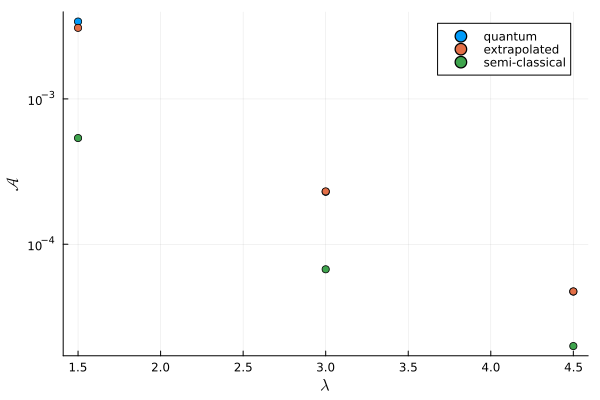

In [259]:
ns = [i for i in 1:15000 if EPRL_cond(0.5*i, rationalize(gamma)) == 1]
dVamp_full = [dressed_Vamp_full[a][n,n] for a in 1:4, n in ns[1:3]]
dVamp_extra = [dressed_Vamp_extra[a][n,n] for a in 1:4, n in ns[1:3]]
dVamp_semi = [dressed_Vamp_semi[a][n,n] for a in 1:4, n in ns[1:3]]
scatter(1.5:1.5:4.5, [dVamp_full[2,:], dVamp_extra[2,:], dVamp_semi[2,:]], yaxis=:log, xlabel=L"$\lambda$", ylabel=L"$\mathcal{A}$", label=["quantum" "extrapolated" "semi-classical"])

In [46]:
spins = vec([(1.5*i, 1.5*j) for i in 1:3, j in 1:3])
dVamp_relerr_full_extra = [vec([abs(dressed_Vamp_full[a][m,n] - dressed_Vamp_extra[a][m,n])/dressed_Vamp_full[a][m,n] for m in [3,6,9], n in [3,6,9]]) for a in 1:4]
dVamp_relerr_full_semi = [vec([abs(dressed_Vamp_full[a][m,n] - dressed_Vamp_semi[a][m,n])/dressed_Vamp_full[a][m,n] for m in [3,6,9], n in [3,6,9]]) for a in 1:4]
fig_dVamp_relerr_exact = scatter([dVamp_relerr_full_extra[2], dVamp_relerr_full_semi[2]], xticks=(1:1:9,spins), yticks=[10.0^i for i in -4:0.5:0], yaxis=:log, 
label= ["extrapolated" "semi-classical"], xlabel=L"$(j,k)$", ylabel=L"$\varepsilon$", legend=:bottomleft, fmt=:png, xtickfontsize=8, ytickfontsize=12, labelfontsize=16, legendfontsize=10)
savefig(fig_dVamp_relerr_exact, "/ssd/ri47hud/codes/Frusta quantum amplitude/figures/dVamp_relerr_exact")

"/ssd/ri47hud/codes/Frusta quantum amplitude/figures/dVamp_relerr_exact.png"

Consider the transition from (dVamp_extra - dVamp_semi) being negative to being positive, as a function of the parameter alpha.

In [ ]:
alpha_range = -0.3:0.0001:0.3
dVamp_full_test = [dressed_QVAmp(SU2_Eamp_full[1:6,1:6], SU2_Vamp_full[1:6,1:6], alpha, gamma) for alpha in alpha_range]
dVamp_extra_test = [dressed_QVAmp(SU2_Eamp_extra[1:39,1:39], SU2_Vamp_extra[1:39,1:39], alpha, gamma) for alpha in alpha_range]
dVamp_semi_test = [Ampl_resc_tensor(alpha, 1.0, 1/3, 0.0, 22.5) for alpha in alpha_range]
dVamp_difference = [[abs(dVamp_extra_test[a][j,j] - dVamp_semi_test[a][j,j]) for a in 1:length(alpha_range)] for j in [3*i for i in 1:15]]
plot(alpha_range, [dVamp_difference[j] for j in 1:15], yaxis=:log, legend=false)

Return probability for gamma = 1/3, jmin = 0.5, jmax = 7500

In [48]:
alphas = [12/36, 16/36, 18/36, 20/36, 24/36]
gamma = 1/3
dVamp_extra_a36 = [dressed_QVAmp(SU2_Eamp_extra, SU2_Vamp_extra, alpha, gamma) for alpha in alphas]

5-element Vector{Matrix{Float64}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 8.61387079295624e-23]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 1.1693159516968497e-17]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 4.308227563235771e-15]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 1.5873233157975772e-12]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 2.1547600588346466e-7]

In [61]:
taus = [10.0^(i) for i in -3:0.5:5]
file_endings = [Int(10*i) for i in -3:0.5:5]
#ev1_semi = zeros(4, 17)
ev1_extra = zeros(5, 17)

for t in 1:17
    for a in 1:5
        tau = file_endings[t]
        rp1 = load("/ssd/ri47hud/codes/Spectral Dimension/RP1/Quantum/rp1_1_15000_g13_$tau.jld", "rp1_EPRL")
        #ev1_semi[a,t] =     QExpval_P1(dressed_Vamp_semi[a], rp1)[1]
        ev1_extra[a,t] =    QExpval_P1(dVamp_extra_a36[a], rp1)[1]
    end
end

#specdim1_semi = [-2*(log(ev1_semi[a,t+1]) - log(ev1_semi[a,t]))/(log(taus[t+1]) - log(taus[t])) for a in 1:4, t in 1:16]

In [64]:
fig_ev1_extra = plot(taus, [ev1_extra[a,:] for a in 1:5], xaxis=:log, yaxis=:log, xlabel=L"$\tau$", ylabel=L"$P_1$", 
label=[L"$\alpha = 1/3$" L"$\alpha = 4/9$" L"$\alpha = 1/2$" L"$\alpha = 5/9$" L"$\alpha = 2/3$"],marker=:circle, markersize=:3.0, markerstrokewidth=0.5, legend=:bottomleft, 
xticks=[10.0^i for i in -4:2:5], yticks=[10.0^i for i in -14:2:0], fmt=:png, xtickfontsize=12, ytickfontsize=12, labelfontsize=16, legendfontsize=12)
savefig(fig_ev1_extra, "/ssd/ri47hud/codes/Frusta quantum amplitude/figures/ev1_extra")

"/ssd/ri47hud/codes/Frusta quantum amplitude/figures/ev1_extra.png"

Spectral dimension with extrapolated amplitude

In [65]:
specdim1_extra = [-2*(log(ev1_extra[a,t+1]) - log(ev1_extra[a,t]))/(log(taus[t+1]) - log(taus[t])) for a in 1:5, t in 1:16]
fig_specdim1_extra = plot(taus[1:16], [specdim1_extra[a,:] for a in 1:5], xlabel=L"$\tau$", ylabel=L"$D_S$", label=[L"$\alpha = 1/3$" L"$\alpha = 4/9$" L"$\alpha = 1/2$" L"$\alpha = 5/9$" L"$\alpha = 2/3$"], 
xaxis=:log, legend=:bottomright, marker=:circle, fmt=:png, markersize=:3.0, markerstrokewidth=0.5, xtickfontsize=12, ytickfontsize=12, labelfontsize=16, legendfontsize=12)
savefig(fig_specdim1_extra, "/ssd/ri47hud/codes/Frusta quantum amplitude/figures/specdim1_extra")

"/ssd/ri47hud/codes/Frusta quantum amplitude/figures/specdim1_extra.png"

Influence of L finite vs. L infinite

In [4]:
dVamp_extra_a05 = dressed_QVAmp(SU2_Eamp_extra, SU2_Vamp_extra, 0.5, 1/3)
taus = [10.0^(i) for i in -2:0.5:4]
file_endings = [Int(10*i) for i in -2:0.5:4]
ev1_L_inf = zeros(17)
for (t, tau) in enumerate(file_endings)
    rp1 = load("/ssd/ri47hud/codes/Spectral Dimension/RP1/Quantum/rp1_1_15000_g13_$tau.jld", "rp1_EPRL")
    ev1_L_inf[t] = QExpval_P1(dVamp_extra_a05, rp1)[1]
end
#ev1_L_finite = QExpval_P1(dVamp_extra_a05, transpose(load("/ssd/ri47hud/codes/Spectral Dimension/RP1/Summation/rp1_sum_1_15000_g13_-2_05_4.jld", "rp1_EPRL")))

In [29]:
#scatter(taus, [ev1_L_inf[1:13], ev1_L_finite], xaxis=:log, yaxis=:log, marker=:3.0)
#specdim_L_inf = [-2*(log(ev1_L_inf[t+1]) - log(ev1_L_inf[t]))/(log(taus[t+1]) - log(taus[t])) for t in 1:12]
#specdim_L_finite = [-2*(log(ev1_L_finite[t+1]) - log(ev1_L_finite[t]))/(log(taus[t+1]) - log(taus[t])) for t in 1:12]
#scatter(taus[1:12], [specdim_L_inf, specdim_L_inf], xaxis=:log, legend=:bottomright)
#ev1_relerr_L_inf_vs_100 = [abs(ev1_L_inf[t] - ev1_L_finite[t])/ev1_L_finite[t] for t in 1:13]
#specdim1_relerr_L_inf_vs_100 = [abs(specdim_L_inf[t] - specdim_L_finite[t])/specdim_L_finite[t] for t in 1:12]
fig_relerr_Linf_vs_L100 = scatter(taus, ev1_relerr_L_inf_vs_100, xaxis=:log, yaxis=:log, legend=false, xlabel=L"$\tau$", ylabel=L"$\varepsilon$")
savefig(fig_relerr_Linf_vs_L100, "/ssd/ri47hud/codes/Frusta quantum amplitude/figures/ev1_relerr_L_inf_vs_100")
#scatter(taus[1:12], specdim1_relerr_L_inf_vs_100, xaxis=:log, yaxis=:log)

"/ssd/ri47hud/codes/Frusta quantum amplitude/figures/ev1_relerr_L_inf_vs_100.png"

Spectral dimension with semi-classical amplitude

In [55]:
dVamp_semi_a05 = Ampl_resc_tensor(0.5, 1.0, 1/3, 0.0, 7500.0)
dVamp_extra_a05 = dressed_QVAmp(SU2_Eamp_extra, SU2_Vamp_extra, 0.5, 1/3)
taus = [10.0^(i) for i in -3:0.5:5]
file_endings = [Int(10*i) for i in -3:0.5:5]
ev1_semi = zeros(17)
ev1_extra = zeros(17)
for (t,tau) in enumerate(file_endings)
    rp1 = load("/ssd/ri47hud/codes/Spectral Dimension/RP1/Quantum/rp1_1_15000_g13_$tau.jld", "rp1_EPRL")
    ev1_semi[t] = QExpval_P1(dVamp_semi_a05, rp1)[1]
    ev1_extra[t] = QExpval_P1(dVamp_extra_a05, rp1)[1]
end

In [57]:
specdim1_semi = [-2*(log(ev1_semi[t+1]) - log(ev1_semi[t]))/(log(taus[t+1]) - log(taus[t])) for t in 1:16]
specdim1_extra = [-2*(log(ev1_extra[t+1]) - log(ev1_extra[t]))/(log(taus[t+1]) - log(taus[t])) for t in 1:16]
fig_specdim_sc_vs_qu = plot(taus[1:16], [specdim1_extra, specdim1_semi], label=["extraploated" "semi-classical"], xaxis=:log, xlabel=L"$\tau$", ylabel=L"D_S", 
legend=:bottomright, fmt=:png, marker=:circle, markersize=:3.0, markerstrokewidth=:0.5, xtickfontsize=12, ytickfontsize=12, labelfontsize=16, legendfontsize=10)
savefig(fig_specdim_sc_vs_qu, "/ssd/ri47hud/codes/Frusta quantum amplitude/figures/specdim_sc_vs_qu")

"/ssd/ri47hud/codes/Frusta quantum amplitude/figures/specdim_sc_vs_qu.png"

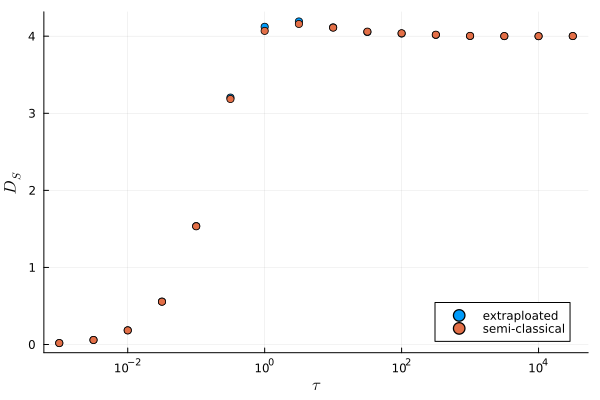

In [22]:
alph = 6/18
dVamp_semi_a718 = Ampl_resc_tensor(alph, 1.0, 1/3, 0.0, 7500.0)
dVamp_extra_a718 = dressed_QVAmp(SU2_Eamp_extra, SU2_Vamp_extra, alph, 1/3)
taus = [10.0^(i) for i in -3:0.5:5]
file_endings = [Int(10*i) for i in -3:0.5:5]
ev1_semi_a718 = zeros(17)
ev1_extra_a718 = zeros(17)
for (t,tau) in enumerate(file_endings)
    rp1 = load("/ssd/ri47hud/codes/Spectral Dimension/RP1/Quantum/rp1_1_15000_g13_$tau.jld", "rp1_EPRL")
    ev1_semi_a718[t] = QExpval_P1(dVamp_semi_a718, rp1)[1]
    ev1_extra_a718[t] = QExpval_P1(dVamp_extra_a718, rp1)[1]
end
specdim1_semi_a718 = [-2*(log(ev1_semi_a718[t+1]) - log(ev1_semi_a718[t]))/(log(taus[t+1]) - log(taus[t])) for t in 1:16]
specdim1_extra_a718 = [-2*(log(ev1_extra_a718[t+1]) - log(ev1_extra_a718[t]))/(log(taus[t+1]) - log(taus[t])) for t in 1:16]
scatter(taus[1:16], [specdim1_extra_a718, specdim1_semi_a718], label=["extraploated" "semi-classical"], xaxis=:log, xlabel=L"$\tau$", ylabel=L"D_S", legend=:bottomright, fmt=:png)